In [1]:
import hopsworks
import pandas as pd
from sklearn.ensemble import IsolationForest
import numpy as np

project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/549021
2024-05-28 12:35:11,642 WARNING: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead

2024-05-28 12:35:11,643 WARNING: using legacy validation callback
Connected. Call `.close()` to terminate connection gracefully.


In [2]:
try: 
    feature_view = fs.get_feature_view(name="spot63", version=1)
except:
    fg = fs.get_feature_group(name="spot63", version=1)
    query = fg.select_all()
    feature_view = fs.create_feature_view(name="spot63",
                                      version=1,
                                      description="sensor 63",
                                      query=query)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/549021/fs/544844/fv/spot63/version/1


In [3]:
feature, labels = feature_view.training_data(
    description = 'spot63 training dataset',
)

features = feature[['x','y','z','temperature','magnitude']]

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.57s) 
2024-05-28 12:35:22,178 WARNING: VersionWarning: Incremented version to `1`.



2024-05-28 12:35:24,612 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2024-05-28 12:35:24,758 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



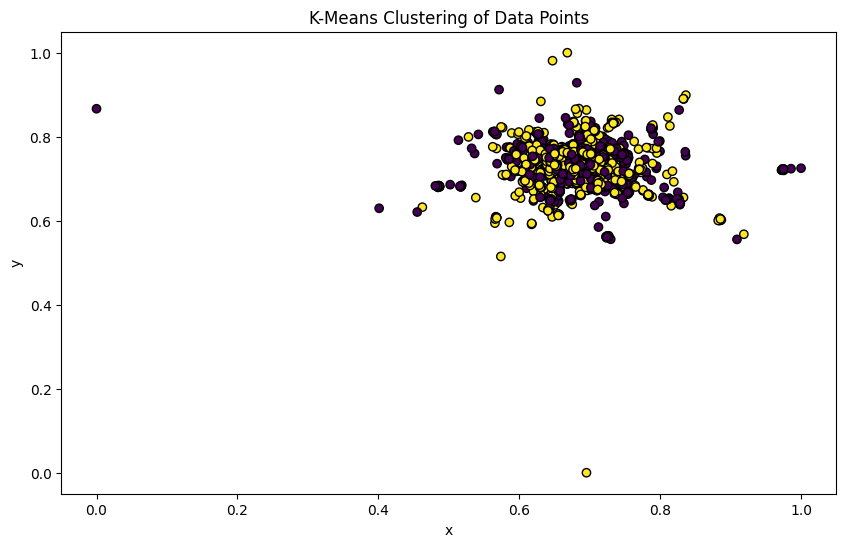

          x         y         z  temperature  magnitude  cluster
0  0.698488  0.730253  0.506383     0.666667   1.130301        0
1  0.689530  0.730253  0.500000     0.666667   1.121927        0
2  0.787794  0.818554  0.435106     0.696970   1.216539        0
3  0.688410  0.730253  0.495745     0.848485   1.119348        0
4  0.674972  0.707154  0.419149     0.696970   1.063644        0


In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt



features['magnitude'] = np.sqrt(features['x']**2 + features['y']**2 + features['z']**2)

kmeans = KMeans(n_clusters=2, random_state=42)  

kmeans.fit(features)

clusters = kmeans.predict(features)

features['cluster'] = clusters

plt.figure(figsize=(10, 6))
plt.scatter(features['x'], features['y'], c=features['cluster'], cmap='viridis', marker='o', edgecolor='k')
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means Clustering of Data Points')
plt.show()

print(features.head())

cluster_counts = features['cluster'].value_counts()
anomaly_cluster = cluster_counts.idxmin()

anomalies = features[features['cluster'] == anomaly_cluster]

anomaly_indices = anomalies.index

In [5]:
features.head(20)

,x,y,z,temperature,magnitude,cluster
0,0.698488,0.730253,0.506383,0.666667,1.130301,0
1,0.689530,0.730253,0.500000,0.666667,1.121927,0
2,0.787794,0.818554,0.435106,0.696970,1.216539,0
3,0.688410,0.730253,0.495745,0.848485,1.119348,0
4,0.674972,0.707154,0.419149,0.696970,1.063644,0
5,0.688970,0.735842,0.502128,0.424242,1.126177,1
6,0.676092,0.782787,0.580851,0.272727,1.186273,1
7,0.675252,0.833830,0.588298,0.333333,1.223655,1
8,0.677772,0.725410,0.477660,0.242424,1.101704,1
9,0.691489,0.730999,0.510638,0.727273,1.128392,0


In [6]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import os
import joblib
import shutil

In [8]:
mr = project.get_model_registry()

model_dir1="spot63_k_nn"
if os.path.isdir(model_dir1) == False:
    os.mkdir(model_dir1)
joblib.dump(kmeans, model_dir1 + "/spot63_k_nn.pkl")



spot63= mr.python.create_model(
    version=1,
    name="spot63_k_nn", 
    description="Anomaly detection- UML")

spot63.save(model_dir1)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/33131 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/549021/models/spot63_k_nn/1


Model(name: 'spot63_k_nn', version: 1)